In [29]:
import pandas as pd
import numpy as np
import torch
import sklearn

### Importing data

In [30]:
from sklearn.model_selection import train_test_split

#Read in data
train = pd.read_csv('data/train.csv')
#Remove any rows with missing values
df = train.dropna(axis=0, how='any') # figure out how to bootstrap
#Drop columns
df = df.drop(['ID', 'Customer_ID', 'Month', 'Name', 'SSN','Num_Credit_Inquiries', 'Payment_Behaviour'], axis=1)

#Removing extra underscores from columns
df['Age'] = df['Age'].str.replace('_', '')
df['Annual_Income'] = df['Annual_Income'].str.replace('_', '')
df['Num_of_Loan'] = df['Num_of_Loan'].str.replace('_', '')
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].str.replace('_', '')
df['Changed_Credit_Limit'] = df['Changed_Credit_Limit'].str.replace('_', '')
df['Outstanding_Debt'] = df['Outstanding_Debt'].str.replace('_', '')
df['Amount_invested_monthly'] = df['Amount_invested_monthly'].str.replace('_', '')
df['Monthly_Balance'] = df['Monthly_Balance'].str.replace('_', '')
df = df.dropna(axis=0, how='any')


df.drop(df[df['Occupation'] == '_______'].index, inplace=True)
df.drop(df[df['Credit_Mix'] == '_'].index, inplace=True)
df.drop(df[df['Changed_Credit_Limit'] == ''].index, inplace=True)
df.drop(df[df['Payment_of_Min_Amount'] == 'NM'].index, inplace=True)

C:\Users\jtcle\AppData\Local\Temp\ipykernel_36876\3997587535.py:4: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('data/train.csv')


In [31]:
#Finding unique loan types and making a new column for each
unique_loans = set()

for row in df['Type_of_Loan']:
    vals = row.split(',')
    for loan in vals:
        unique = loan.lstrip(' and').strip()
        unique_loans.add(unique)

unique_loans.remove('Not Specified')

temp = pd.DataFrame(columns=list(unique_loans), data=np.zeros(shape=(len(df), len(unique_loans)), dtype=np.int8))
# print(temp)

# Updating the columns with correct loans
for i, row in enumerate(df['Type_of_Loan']):
    for loan in unique_loans:
        temp.at[i, loan] = row.count(loan)

# print(temp)
df = pd.concat([df.drop('Type_of_Loan', axis=1).reset_index(drop=True), temp.reset_index(drop=True)], axis=1)

print(df)

      Age Occupation      Annual_Income  Monthly_Inhand_Salary  \
0      23  Scientist           19114.12            1824.843333   
1      28    Teacher           34847.84            3037.986667   
2      28    Teacher           34847.84            3037.986667   
3      28    Teacher           34847.84            3037.986667   
4      28    Teacher           34847.84            3037.986667   
...    ..        ...                ...                    ...   
33397  24     Lawyer  59868.93000000001            5111.077500   
33398  31  Developer           28796.82            2378.735000   
33399  32  Developer           28796.82            2378.735000   
33400  38     Lawyer           41015.55            3152.962500   
33401  38     Lawyer           41015.55            3152.962500   

       Num_Bank_Accounts  Num_Credit_Card  Interest_Rate Num_of_Loan  \
0                      3                4              3           4   
1                      2                4              6       

In [32]:
#Changing credit history to be in terms of months
#df.dropna(axis=0, how='any', inplace=True)
temp = pd.DataFrame(columns=['Credit_History_Age'], data=np.zeros(shape=(len(df), 1), dtype=np.int8))
zero_count = 0

for i, row in enumerate(df['Credit_History_Age']):
        age_series = row.split(' and ')
        years = int(age_series[0].rstrip('Years').strip())
        months = int(age_series[1].rstrip('Months').strip())
        temp.at[i, 'Credit_History_Age'] = years*12+months

df = pd.concat([df.drop('Credit_History_Age', axis=1).reset_index(drop=True), temp.reset_index(drop=True)], axis=1)

print(df)

      Age Occupation      Annual_Income  Monthly_Inhand_Salary  \
0      23  Scientist           19114.12            1824.843333   
1      28    Teacher           34847.84            3037.986667   
2      28    Teacher           34847.84            3037.986667   
3      28    Teacher           34847.84            3037.986667   
4      28    Teacher           34847.84            3037.986667   
...    ..        ...                ...                    ...   
33397  24     Lawyer  59868.93000000001            5111.077500   
33398  31  Developer           28796.82            2378.735000   
33399  32  Developer           28796.82            2378.735000   
33400  38     Lawyer           41015.55            3152.962500   
33401  38     Lawyer           41015.55            3152.962500   

       Num_Bank_Accounts  Num_Credit_Card  Interest_Rate Num_of_Loan  \
0                      3                4              3           4   
1                      2                4              6       

In [33]:
#Get columns ready to encode
encoding_columns = ['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount']
data_to_encode = df[encoding_columns]


#Creating a OneHotEncoder   
ohe = sklearn.preprocessing.OneHotEncoder()

ohe.fit(data_to_encode)
encoded = ohe.transform(data_to_encode)

#Get feature names
feature_names = ohe.get_feature_names_out(input_features=encoding_columns)
ohe_df = pd.DataFrame.sparse.from_spmatrix(encoded, columns=feature_names)


encoded_df = pd.DataFrame(encoded.toarray(), columns=feature_names)

final_df = pd.concat([df.drop(encoding_columns, axis=1), encoded_df], axis=1)

print(final_df)
print(final_df.shape)

      Age      Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0      23           19114.12            1824.843333                  3   
1      28           34847.84            3037.986667                  2   
2      28           34847.84            3037.986667                  2   
3      28           34847.84            3037.986667                  2   
4      28           34847.84            3037.986667                  2   
...    ..                ...                    ...                ...   
33397  24  59868.93000000001            5111.077500                  4   
33398  31           28796.82            2378.735000                  6   
33399  32           28796.82            2378.735000                  6   
33400  38           41015.55            3152.962500               1194   
33401  38           41015.55            3152.962500                  0   

       Num_Credit_Card  Interest_Rate Num_of_Loan  Delay_from_due_date  \
0                    4              3

In [34]:
# Change variable types of columns
final_df = final_df.astype({'Age': float, 'Annual_Income' : float, 'Num_of_Loan': float, 'Num_of_Delayed_Payment': float,'Changed_Credit_Limit': float, 'Outstanding_Debt': float, 'Amount_invested_monthly': float, 'Monthly_Balance': float})

In [35]:
to_standardize = ['Num_Bank_Accounts', 'Annual_Income', 'Monthly_Inhand_Salary', 'Changed_Credit_Limit', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
              'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
              'Num_of_Delayed_Payment', 'Age', 'Credit_History_Age']
pd.set_option('display.max_columns', None)
for col in final_df.columns:
    if col in to_standardize:
        final_df[col] = (final_df[col] - final_df[col].mean())/final_df[col].std()

# print(final_df)

In [47]:
def numeric_encode(y):
    if y == "Good":
        # return torch.tensor([1, 0, 0]).to(torch.float32)
        return 0
    if y == "Standard":
        # return torch.tensor([0, 1, 0]).to(torch.float32)
        return 1
    # return torch.tensor([0, 0, 1]).to(torch.float32)
    return 2

final_df['Credit_Score'] = list(map(numeric_encode, final_df['Credit_Score'].values))

x = final_df.drop(['Credit_Score'], axis=1).values
y = final_df['Credit_Score'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, train_size=0.7)

### Decision Tree

accuracy : 0.6806705917573096
[[ 948  577  103]
 [ 534 3801  939]
 [  93  954 2072]]


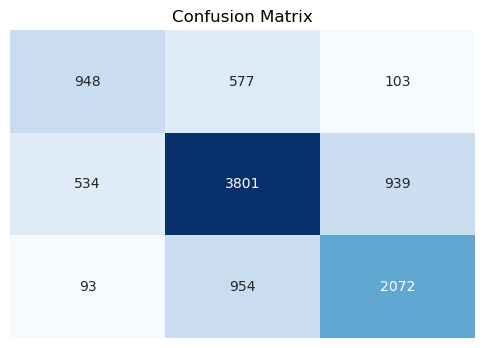

In [37]:
from sklearn import tree, metrics
import seaborn as sns 
import matplotlib.pyplot as plt

# makes a decision tree using x/y train data
dtc = tree.DecisionTreeClassifier().fit(x_train, y_train)

# use model for pred
y_pred_dtc = dtc.predict(x_test)

# getting statistics
accuracy = metrics.accuracy_score(y_test, y_pred_dtc)
# precision = metrics.precision_score(y_test, y_pred_dtc)
# recall = metrics.recall_score(y_test, y_pred_dtc)
# f1 = metrics.f1_score(y_test, y_pred_dtc)
cm = metrics.confusion_matrix(y_test, y_pred_dtc)

print(f'accuracy : {accuracy}')
# print(f'precision : {precision}')
# print(f'recall : {recall}')
# print(f'f1 : {f1}')
print(cm)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=False, yticklabels=False, cbar=False)
plt.title('Confusion Matrix')
plt.show()

Accuracy: 0.7735754914679174
[[1119  492   17]
 [ 386 4211  677]
 [  52  645 2422]]


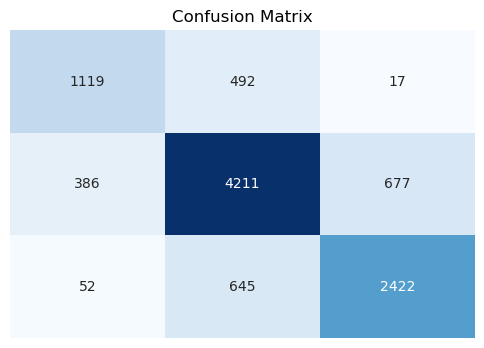

In [38]:
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier()
rfc = rfc.fit(x_train, y_train)

y_pred_rfc = rfc.predict(x_test)

# Calculate the accuracy, precision, recall, and F1 score
accuracy = metrics.accuracy_score(y_test, y_pred_rfc)
# precision = metrics.precision_score(y_test, y_pred_rfc)
# recall = metrics.recall_score(y_test, y_pred_rfc)
# f1 = metrics.f1_score(y_test, y_pred_rfc)
cm = metrics.confusion_matrix(y_test, y_pred_rfc)

# Print the results
print('Accuracy:', accuracy)
# print('Precision:', precision)
# print('Recall:', recall)
# print('F1 score:', f1)
print(cm)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=False, yticklabels=False, cbar=False)
plt.title('Confusion Matrix')
plt.show()

In [39]:
# from sklearn import neighbors
# # Create a KNN classifier and fit it to the training data
# knn = neighbors.KNeighborsClassifier(leaf_size=500)
# knn.fit(x_train, y_train)

# # Predict the labels of the test data
# y_pred_knn = knn.predict(x_test)

# # Calculate the accuracy, precision, recall, and F1 score
# accuracy = metrics.accuracy_score(y_test, y_pred_knn)
# cm = metrics.confusion_matrix(y_test, y_pred_rfc)
# # precision = metrics.precision_score(y_test, y_pred)
# # recall = metrics.recall_score(y_test, y_pred)
# # f1 = metrics.f1_score(y_test, y_pred)

# # Print the results
# print('Accuracy:', accuracy)
# # print('Precision:', precision)
# # print('Recall:', recall)
# # print('F1 score:', f1)
# print(cm)

# # Create a heatmap of the confusion matrix
# plt.figure(figsize=(6, 4))
# sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=False, yticklabels=False, cbar=False)
# plt.title('Confusion Matrix')
# plt.show()

In [40]:
#Changing all columns to float type
def to_float(x):
    return torch.tensor(x).to(torch.float32)

training_data = list(zip(map(to_float, x_train), y_train))
test_data = list(zip(map(to_float, x_test), y_test))

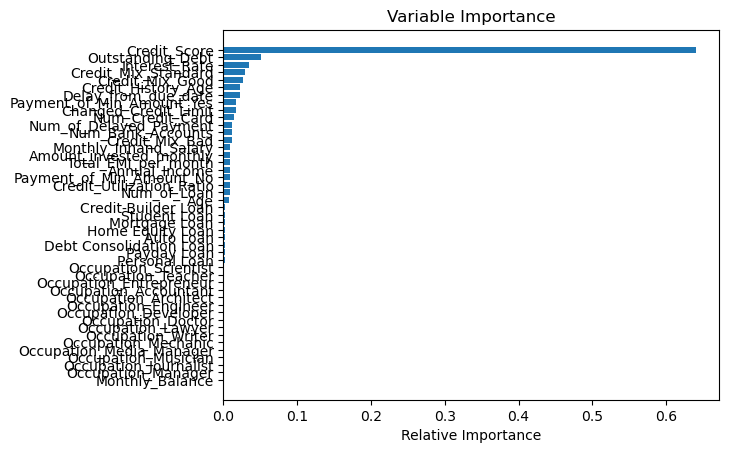

In [49]:
# Feature Selection
features = np.array(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Outstanding_Debt',
'Credit_Utilization_Ratio', 'Total_EMI_per_month',
'Amount_invested_monthly', 'Monthly_Balance', 'Credit_Score',
'Personal Loan', 'Auto Loan', 'Mortgage Loan', 'Credit-Builder Loan',
'Debt Consolidation Loan', 'Student Loan', 'Payday Loan', 'Home Equity Loan',
'Credit_History_Age', 'Occupation_Accountant', 'Occupation_Architect',
'Occupation_Developer', 'Occupation_Doctor', 'Occupation_Engineer',
'Occupation_Entrepreneur', 'Occupation_Journalist', 'Occupation_Lawyer',
'Occupation_Manager', 'Occupation_Mechanic', 'Occupation_Media_Manager',
'Occupation_Musician', 'Occupation_Scientist', 'Occupation_Teacher',
'Occupation_Writer', 'Credit_Mix_Bad', 'Credit_Mix_Good',
'Credit_Mix_Standard', 'Payment_of_Min_Amount_No',
'Payment_of_Min_Amount_Yes'])

clf = ensemble.RandomForestClassifier()
clf.fit(final_df[features], final_df['Credit_Score'])

importances = clf.feature_importances_
sorted_idx = np.argsort(importances)

padding = np.arange(len(features)) + 0.5
plt.barh(padding, importances[sorted_idx], align='center')
plt.yticks(padding, features[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

In [26]:
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True, drop_last=True)

# choose device
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
print(f"using {device} device")

# subclass
class NeuralNetwork(nn.Module): # getting stuck at 67%
    def __init__(self):
        super().__init__()
        # Linear Relu Structure
        # self.structure = nn.Sequential(
        #     nn.Linear(44, 512),
        #     nn.ReLU(),
        #     nn.Linear(512, 512),
        #     nn.ReLU(),
        #     nn.Linear(512, 3),
        # )

        # deeper NN
        # self.structure = nn.Sequential(
        #     nn.Linear(44, 512),
        #     nn.ReLU(),
        #     nn.Dropout(p=0.2),
        #     nn.Linear(512, 1024),
        #     nn.Tanh(),
        #     nn.Linear(1024, 1024),
        #     nn.ReLU(),
        #     nn.Linear(1024, 512),
        #     nn.Sigmoid(),
        #     nn.Linear(512, 512),
        #     nn.ReLU(),
        #     nn.Linear(512, 3),
        # )

        # Fewer nodes
        self.structure = nn.Sequential(
            nn.Linear(44, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 3),
        )

    def forward(self, x):
        logits = self.structure(x)
        return logits


model = NeuralNetwork().to(device)


using cpu device


In [29]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # print(X.size())
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

y_pred_nn = []
y_actual_nn = []
def test_loop(dataloader, model, loss_fn):
    y_pred_nn.clear()
    y_actual_nn.clear()
    print('ran')
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            y_pred_nn.append(pred.max(dim=1).indices)
            y_actual_nn.append(y)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.max(dim=1).indices ==
                        y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


# parameters
learning_rate = 1e-2
# batch_size = 64
epochs = 30

# implementation
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 0.752540  [   64/23381]
loss: 0.700099  [ 6464/23381]
loss: 0.751470  [12864/23381]
loss: 0.693819  [19264/23381]
ran
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.717260 

Epoch 2
-------------------------------
loss: 0.671602  [   64/23381]
loss: 0.626397  [ 6464/23381]
loss: 0.571758  [12864/23381]
loss: 0.733360  [19264/23381]
ran
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.715928 

Epoch 3
-------------------------------
loss: 0.629307  [   64/23381]
loss: 0.769516  [ 6464/23381]
loss: 0.723748  [12864/23381]
loss: 0.543072  [19264/23381]
ran
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.716135 

Epoch 4
-------------------------------
loss: 0.617273  [   64/23381]
loss: 0.665746  [ 6464/23381]
loss: 0.735185  [12864/23381]
loss: 0.571309  [19264/23381]
ran
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.716027 

Epoch 5
-------------------------------
loss: 0.819922  [   64/23381]
loss: 0.731920  [ 6464/23381]
loss: 0.753464  [12864/23381]
loss: 

ran
Test Error: 
 Accuracy: 63.6%, Avg loss: 0.748483 



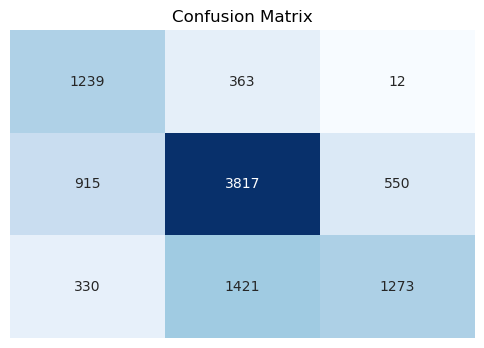

In [15]:
test_loop(test_dataloader, model, loss_fn)
y_pred_nn_cm = torch.flatten(torch.stack(y_pred_nn[:len(y_pred_nn)-1], 0)).cpu().detach().numpy()
y_actual_nn_cm = torch.flatten(torch.stack(y_actual_nn[:len(y_actual_nn)-1], 0)).cpu().detach().numpy()

# print(y_pred_nn)
# print(y_pred_nn)
# print(y_actual_nn.flatten())
cm_nn = metrics.confusion_matrix(y_actual_nn_cm, y_pred_nn_cm)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_nn, annot=True, cmap='Blues', fmt='g', xticklabels=False, yticklabels=False, cbar=False)
plt.title('Confusion Matrix')
plt.show()


In [16]:
# save model
torch.save(model.state_dict(), 'credit_score_lin_relu.pth')

In [17]:
# load model
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load('credit_score_lin_relu.pth'))
model.eval()  # set to testing mode

NeuralNetwork(
  (structure): Sequential(
    (0): Linear(in_features=44, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=1024, bias=True)
    (4): Tanh()
    (5): Linear(in_features=1024, out_features=1024, bias=True)
    (6): ReLU()
    (7): Linear(in_features=1024, out_features=512, bias=True)
    (8): Sigmoid()
    (9): Linear(in_features=512, out_features=512, bias=True)
    (10): ReLU()
    (11): Linear(in_features=512, out_features=3, bias=True)
  )
)